In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/Administrator/Desktop/pipelines/order_data/data2.csv')
df.head(5)

,title,annotations,target
0,ФАКТОР НАСЛЕДСТВЕННОЙ ТРОМБОФИЛИИ У ПАЦИЕНТОК ...,618.145-007.415:575_x000D_\n_x000D_\nФАКТОР НА...,"Научные основы охраны здоровья матери, женщины..."
1,ОПЫТ ИСПОЛЬЗОВАНИЯ МЕТОДИК ТЕРОПЕВТИЧЕСКОЙ РЕК...,ОПЫТ ИСПОЛЬЗОВАНИЯ МЕТОДИК ТЕРОПЕВТИЧЕСКОЙ РЕК...,Трудный диагноз в педиатрии: от практики к науке.
2,Сравнительная характеристика Нр-позитивного и ...,Сравнительная характеристика Нр-позитивного и ...,Возрастные особенности формирования здоровья в...
3,Современные подходы к лечению постравматически...,Современные подходы к лечению постравматически...,Трудный диагноз в клинике внутренних болезней.
4,Современные аспекты диагностики и лечения ВМД,Современные аспекты диагностики и лечения ВМД,"Разработка новых методов профилактики, прогноз..."


<AxesSubplot:title={'center':'Count (target)'}>

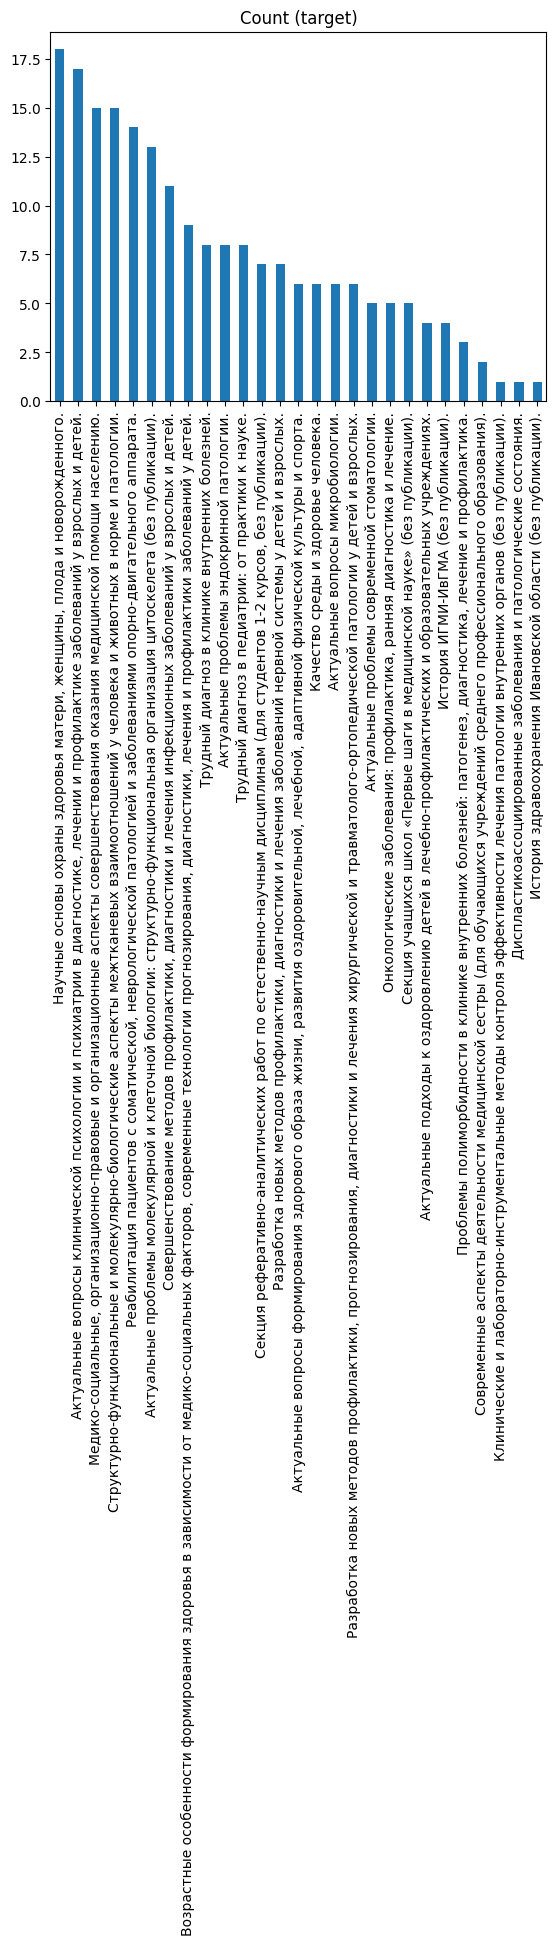

In [3]:
df['target'].value_counts().plot(kind='bar', title='Count (target)')

In [4]:
unk_labels = [df['target'].value_counts()[df['target'].value_counts() < 5].index[i] for i in range(len(df['target'].value_counts()[df['target'].value_counts() < 5]))]

In [5]:
unk_labels

['Актуальные подходы к оздоровлению детей в лечебно-профилактических и образовательных учреждениях.',
 'История ИГМИ-ИвГМА (без публикации).',
 'Проблемы полиморбидности в клинике внутренних болезней: патогенез, диагностика, лечение и профилактика.',
 'Современные аспекты деятельности медицинской сестры (для обучающихся учреждений среднего профессионального образования).',
 'Клинические и лабораторно-инструментальные методы контроля эффективности лечения патологии внутренних органов (без публикации).',
 'Диспластикоассоциированные заболевания и патологические состояния.',
 'История здравоохранения Ивановской области (без публикации).']

<AxesSubplot:title={'center':'Count (target)'}>

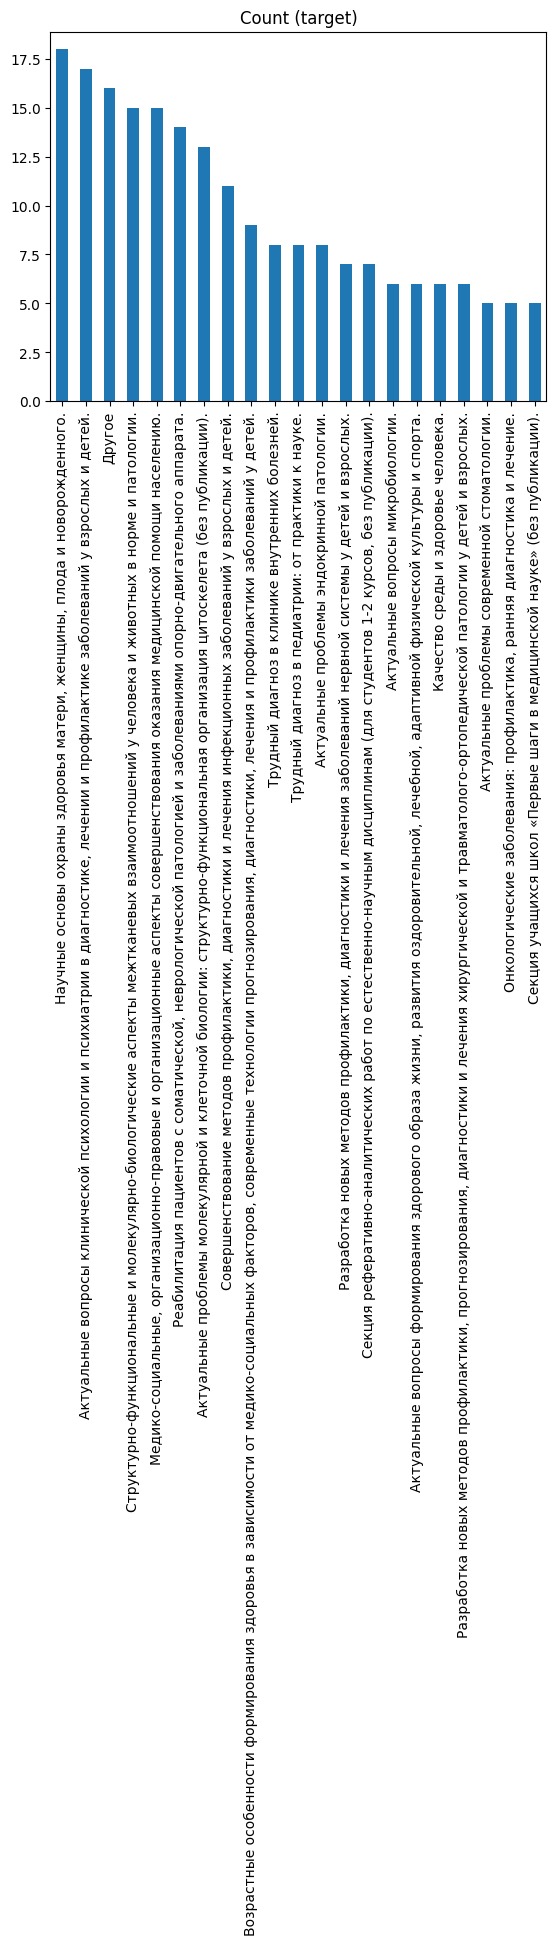

In [6]:
df['target'] = df['target'].apply(lambda x: 'Другое' if x in unk_labels else x)
df['target'].value_counts().plot(kind='bar', title='Count (target)')


In [7]:
df[df['target'].isin(unk_labels)]

,title,annotations,target


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        205 non-null    object
 1   annotations  205 non-null    object
 2   target       205 non-null    object
dtypes: object(3)
memory usage: 4.9+ KB


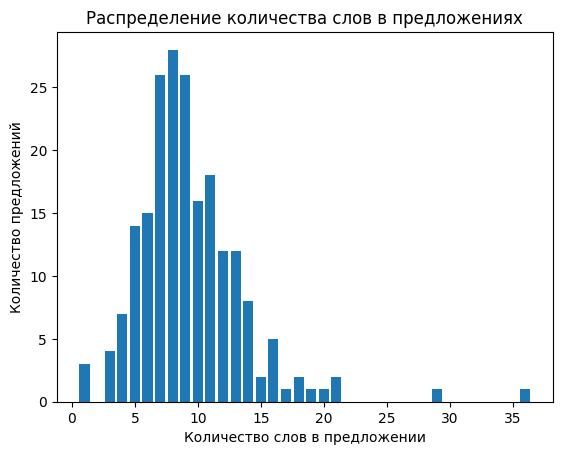

In [9]:
len_df = pd.DataFrame(df).copy()

# Добавляем столбец с количеством слов в предложении
len_df['word_count'] = df['title'].apply(lambda x: len(x.split()))

# Строим гистограмму
plt.hist(len_df['word_count'], bins=range(min(len_df['word_count']), max(len_df['word_count']) + 1, 1), rwidth=0.8, align='left')
plt.xlabel('Количество слов в предложении')
plt.ylabel('Количество предложений')
plt.title('Распределение количества слов в предложениях')
plt.show()

In [10]:
df = df.drop('annotations', axis=1)
df.columns

Index(['title', 'target'], dtype='object')

In [11]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
import torch
from torch import nn
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.optim import Adam, SGD, RMSprop, Adagrad, Adadelta
from tqdm import tqdm

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
model_name = "distilbert-base-cased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name, truncation=True, do_lower_case=True)

In [14]:
labels = {}
for index, label in enumerate(df['target'].unique()):
    labels[label] = index
labels

{'Научные основы охраны здоровья матери, женщины, плода и новорожденного.': 0,
 'Трудный диагноз в педиатрии: от практики к науке.': 1,
 'Возрастные особенности формирования здоровья в зависимости от медико-социальных факторов, современные технологии прогнозирования, диагностики, лечения и профилактики заболеваний у детей.': 2,
 'Трудный диагноз в клинике внутренних болезней.': 3,
 'Разработка новых методов профилактики, прогнозирования, диагностики и лечения хирургической и травматолого-ортопедической патологии у детей и взрослых.': 4,
 'Разработка новых методов профилактики, диагностики и лечения заболеваний нервной системы у детей и взрослых.': 5,
 'Актуальные вопросы клинической психологии и психиатрии в диагностике, лечении и профилактике заболеваний у взрослых и детей.': 6,
 'Другое': 7,
 'Структурно-функциональные и молекулярно-биологические аспекты межтканевых взаимоотношений у человека и животных в норме и патологии.': 8,
 'Актуальные проблемы молекулярной и клеточной биологии

In [15]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length):
        self.labels = [labels[label] for label in df['target']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = max_length, truncation=True,
                                return_tensors="pt") for text in df['title']]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [16]:
np.random.seed(112)
df_train, df_test_val = np.split(df.sample(frac=1, random_state=42),
                                     [int(.7*len(df))])
df_val, df_test = np.split(df_test_val.sample(frac=1, random_state=42),
                                     [int(.5*len(df_test_val))])

print(len(df_train),len(df_val), len(df_test))

143 31 31


In [17]:
arch1_train_acc = []
arch1_valid_acc = []

In [18]:
BATCH_SIZE=8
LEARNING_RATE=1e-6
EPOCHS=20
MAX_LEN = 64

In [19]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.dropout = nn.Dropout(0.12)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 21)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        last_hidden_state = self.bert(input_ids=input_id, attention_mask=mask).last_hidden_state
        pooled_output = last_hidden_state[:, 0]
        # linear_output = nn.functional.relu(self.linear(pooled_output))
        dropped_output = self.dropout(pooled_output)
        logits = self.classifier(dropped_output)
        final_layer = self.softmax(logits)

        return final_layer

In [20]:
model = BertClassifier()

In [21]:
def train(model, epochs):
    train, val = Dataset(df_train, MAX_LEN), Dataset(df_val, MAX_LEN)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)


    if use_cuda:
            print('on cuda')
            model = model.cuda()
            criterion = criterion.cuda()

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                model.zero_grad()

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc


                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            arch1_train_acc.append(total_acc_train / len(df_train))
            arch1_valid_acc.append(total_acc_val / len(df_val))

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
                | Train Accuracy: {total_acc_train / len(df_train): .3f} \
                | Val Loss: {total_loss_val / len(df_val): .3f} \
                | Val Accuracy: {total_acc_val / len(df_val): .3f}')

In [22]:
print('Adam, BS=16, lr=1e-6, ls=0.05')
print(LEARNING_RATE)
train(model, EPOCHS)

Adam, BS=16, lr=1e-6, ls=0.05
1e-06
on cuda


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 18/18 [00:01<00:00, 11.17it/s]


Epochs: 1 | Train Loss:  0.383                 | Train Accuracy:  0.056                 | Val Loss:  0.393                 | Val Accuracy:  0.000


100%|██████████| 18/18 [00:01<00:00, 15.73it/s]


Epochs: 2 | Train Loss:  0.383                 | Train Accuracy:  0.084                 | Val Loss:  0.393                 | Val Accuracy:  0.000


100%|██████████| 18/18 [00:01<00:00, 15.22it/s]


Epochs: 3 | Train Loss:  0.383                 | Train Accuracy:  0.063                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 14.81it/s]


Epochs: 4 | Train Loss:  0.383                 | Train Accuracy:  0.049                 | Val Loss:  0.393                 | Val Accuracy:  0.000


100%|██████████| 18/18 [00:01<00:00, 14.51it/s]


Epochs: 5 | Train Loss:  0.383                 | Train Accuracy:  0.084                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 13.90it/s]


Epochs: 6 | Train Loss:  0.383                 | Train Accuracy:  0.084                 | Val Loss:  0.392                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 13.97it/s]


Epochs: 7 | Train Loss:  0.383                 | Train Accuracy:  0.021                 | Val Loss:  0.392                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 14.03it/s]


Epochs: 8 | Train Loss:  0.383                 | Train Accuracy:  0.126                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 13.84it/s]


Epochs: 9 | Train Loss:  0.383                 | Train Accuracy:  0.091                 | Val Loss:  0.392                 | Val Accuracy:  0.097


100%|██████████| 18/18 [00:01<00:00, 13.52it/s]


Epochs: 10 | Train Loss:  0.382                 | Train Accuracy:  0.084                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 13.65it/s]


Epochs: 11 | Train Loss:  0.382                 | Train Accuracy:  0.105                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 12.23it/s]


Epochs: 12 | Train Loss:  0.382                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 10.88it/s]


Epochs: 13 | Train Loss:  0.382                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 10.80it/s]


Epochs: 14 | Train Loss:  0.381                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 11.32it/s]


Epochs: 15 | Train Loss:  0.380                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00,  9.00it/s]


Epochs: 16 | Train Loss:  0.379                 | Train Accuracy:  0.098                 | Val Loss:  0.394                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00, 10.17it/s]


Epochs: 17 | Train Loss:  0.379                 | Train Accuracy:  0.098                 | Val Loss:  0.394                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:01<00:00,  9.23it/s]


Epochs: 18 | Train Loss:  0.379                 | Train Accuracy:  0.098                 | Val Loss:  0.394                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:02<00:00,  7.40it/s]


Epochs: 19 | Train Loss:  0.378                 | Train Accuracy:  0.098                 | Val Loss:  0.394                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:02<00:00,  7.35it/s]


Epochs: 20 | Train Loss:  0.378                 | Train Accuracy:  0.098                 | Val Loss:  0.394                 | Val Accuracy:  0.032


In [23]:
from transformers import RobertaTokenizer, RobertaModel

In [24]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name, truncation=True, do_lower_case=True, return_tensors='pt')

In [25]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = RobertaModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.dropout = nn.Dropout(0.12)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 21)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        last_hidden_state = self.bert(input_ids=input_id, attention_mask=mask).last_hidden_state
        pooled_output = last_hidden_state[:, 0]
        # linear_output = nn.functional.relu(self.linear(pooled_output))
        dropped_output = self.dropout(pooled_output)
        logits = self.classifier(dropped_output)
        final_layer = self.softmax(logits)

        return final_layer

In [26]:
model = BertClassifier()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
arch3_train_acc = []
arch3_valid_acc = []

In [28]:
def train(model, epochs):
    train, val = Dataset(df_train, MAX_LEN), Dataset(df_val, MAX_LEN)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)


    if use_cuda:
            print('on cuda')
            model = model.cuda()
            criterion = criterion.cuda()

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                model.zero_grad()

                output = model(input_id, mask)
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc


                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            arch3_train_acc.append(total_acc_train / len(df_train))
            arch3_valid_acc.append(total_acc_val / len(df_val))

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
                | Train Accuracy: {total_acc_train / len(df_train): .3f} \
                | Val Loss: {total_loss_val / len(df_val): .3f} \
                | Val Accuracy: {total_acc_val / len(df_val): .3f}')

In [29]:
print(f'Adam, BS={BATCH_SIZE}, lr={LEARNING_RATE}, ls=0.05')
print(LEARNING_RATE)
train(model, EPOCHS)

Adam, BS=8, lr=1e-06, ls=0.05
1e-06
on cuda


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 18/18 [00:06<00:00,  2.96it/s]


Epochs: 1 | Train Loss:  0.383                 | Train Accuracy:  0.035                 | Val Loss:  0.393                 | Val Accuracy:  0.097


100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


Epochs: 2 | Train Loss:  0.383                 | Train Accuracy:  0.070                 | Val Loss:  0.393                 | Val Accuracy:  0.065


100%|██████████| 18/18 [00:08<00:00,  2.05it/s]


Epochs: 3 | Train Loss:  0.383                 | Train Accuracy:  0.063                 | Val Loss:  0.393                 | Val Accuracy:  0.000


100%|██████████| 18/18 [00:07<00:00,  2.35it/s]


Epochs: 4 | Train Loss:  0.383                 | Train Accuracy:  0.091                 | Val Loss:  0.393                 | Val Accuracy:  0.000


100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Epochs: 5 | Train Loss:  0.383                 | Train Accuracy:  0.105                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Epochs: 6 | Train Loss:  0.383                 | Train Accuracy:  0.105                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Epochs: 7 | Train Loss:  0.383                 | Train Accuracy:  0.105                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Epochs: 8 | Train Loss:  0.383                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Epochs: 9 | Train Loss:  0.383                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


Epochs: 10 | Train Loss:  0.382                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Epochs: 11 | Train Loss:  0.382                 | Train Accuracy:  0.098                 | Val Loss:  0.392                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Epochs: 12 | Train Loss:  0.381                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.37it/s]


Epochs: 13 | Train Loss:  0.380                 | Train Accuracy:  0.098                 | Val Loss:  0.394                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Epochs: 14 | Train Loss:  0.379                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Epochs: 15 | Train Loss:  0.379                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Epochs: 16 | Train Loss:  0.379                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


Epochs: 17 | Train Loss:  0.379                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Epochs: 18 | Train Loss:  0.378                 | Train Accuracy:  0.098                 | Val Loss:  0.392                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


Epochs: 19 | Train Loss:  0.377                 | Train Accuracy:  0.098                 | Val Loss:  0.392                 | Val Accuracy:  0.032


100%|██████████| 18/18 [00:07<00:00,  2.37it/s]


Epochs: 20 | Train Loss:  0.377                 | Train Accuracy:  0.098                 | Val Loss:  0.393                 | Val Accuracy:  0.032


In [30]:
def evaluate(model, test_data):

    test = Dataset(test_data, 64)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print('Классификация текста')
    print('Персональный набор данных')
    print('Cross entropy loss, label smoothing: 0.1')
    print('AdamW', 'Learning rate: 5e-06', 'Weight decay: 1e-04', sep=", ")
    print(f'Точность: {total_acc_test * 100/ len(test_data): .2f}%')

evaluate(model, df_test)

Классификация текста
Персональный набор данных
Cross entropy loss, label smoothing: 0.1
AdamW, Learning rate: 5e-06, Weight decay: 1e-04
Точность:  0.00%
